In [1]:
import numpy as np
import tensorflow as tf
from image_utils import image_from_url
from lstm import MaxLikelihoodLSTM, PolicyGradientLSTM
from data import PGData, COCOData

In [2]:
def initialize_uninitialized(sess):
    ruv = set(sess.run(tf.report_uninitialized_variables()))
    uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
    tf.variables_initializer(uv).run()

In [3]:
data = COCOData()
pgdata = PGData()

In [4]:
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

tf.reset_default_graph()
sess.close()

In [5]:
sess = tf.InteractiveSession()
lstm = PolicyGradientLSTM(tf.constant(pgdata.word_embedding, dtype=tf.float32), learning_rate=5e-4, batch_size=100)

lstm.load_model(sess, "models/mle500")
initialize_uninitialized(sess)

INFO:tensorflow:Restoring parameters from models/mle500


In [6]:
losses = []
actions = []
rewards = []
advantages = []
end_masks = []

In [8]:
for i in range(50):
    loss, action, reward, advantage = lstm.train(sess, pgdata)
    pgdata.shuffle()
    print(np.mean(loss), np.var(action), np.mean(reward), np.mean(advantage))
    print("------------")
    losses.extend(loss)
    actions.extend(action)
    rewards.extend(reward)
    advantages.extend(advantage)

{'image_id': '1681', 'caption': 'a <UNK> in a kitchen next to <UNK> with a <UNK> with <UNK> in a <UNK>'}
[{'caption': 'a sandwich with cheese and vegetables on a piece of plastic <END>'}, {'caption': 'a take out sandwich on a <UNK> <UNK> <END>'}, {'caption': 'a picture of a <UNK> sandwich with cheese and <UNK> <END>'}, {'caption': 'a sandwich with <UNK> and various other vegetables on top of a plastic bag <END>'}, {'caption': 'a close up of a sandwich in plastic <END>'}]
1.02985 11647.0913184 1.38443211014 0.740971285151
------------
{'image_id': '82178', 'caption': 'a <UNK> of a brown <UNK> of a brown chair <END>'}
[{'caption': 'fire hydrant has two <UNK> on it to <UNK> it a face <END>'}, {'caption': 'a fire hydrant with a face painted on the front in an open field <END>'}, {'caption': 'a fire hydrant is <UNK> at the bottom of a grassy hill <END>'}, {'caption': 'a grey fire hydrant with <UNK> eyes on it on grassy hill <END>'}, {'caption': 'a gray fire hydrant in the middle of an open 

0.672183 6692.28058594 1.41918448921 0.64209840138
------------
{'image_id': '8457', 'caption': 'a wooden corner of a motorcycle <UNK> a <UNK> <END>'}
[{'caption': 'three people are on a sidewalk with a fire hydrant <END>'}, {'caption': '<UNK> guys and a girl are posing in front of a street sign <END>'}, {'caption': 'people are posing by a fire hydrant and a stop light <END>'}, {'caption': 'three people posing for a picture with a street sign and a fire hydrant <END>'}, {'caption': 'the three friends are posing for a photo next to the fire hydrant <END>'}]
0.677008 4500.83104844 1.46426530638 0.627937002316
------------
{'image_id': '49306', 'caption': 'a group of <UNK> <UNK> over a <UNK> of a building for a <UNK> <END>'}
[{'caption': 'people and their motor <UNK> waiting on a city corner <END>'}, {'caption': 'four people are on the street corner two are using cell phones <END>'}, {'caption': 'four people are standing on the sidewalk waiting for the bus <END>'}, {'caption': 'two women 

0.600187 2594.77062344 1.49171339754 0.741292311337
------------
{'image_id': '17451', 'caption': 'a <UNK> with a person standing in a <UNK> on a couch <END>'}
[{'caption': 'a group of adults at an asian fruit market <END>'}, {'caption': 'a fruit market outdoors with about five women <UNK> it <END>'}, {'caption': 'a number of fruits on plastic containers <END>'}, {'caption': 'several people shop around an outdoor vegetable market <END>'}, {'caption': 'there is <UNK> of fresh fruit being <UNK> at the market <END>'}]
0.625679 3757.02786094 1.45889568085 0.768431634318
------------
{'image_id': '32646', 'caption': 'a <UNK> on a <UNK> in a <UNK> <END>'}
[{'caption': 'a laptop computer sitting on a wooden table next to a mouse <END>'}, {'caption': 'apple computers <UNK> and <UNK> new <UNK> mouse <END>'}, {'caption': 'a white apple mouse in front of an apple laptop <END>'}, {'caption': 'a white mouse and a laptop on a tan table <END>'}, {'caption': 'a laptop computer sitting on a desk next t

In [7]:
tf.reset_default_graph()
sess.close()

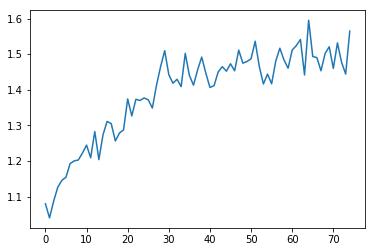

In [18]:
import matplotlib.pyplot as plt

rewards_arr = np.array(rewards)
plt.plot(np.mean(np.reshape(rewards_arr[:, -1], (75, 100)), axis=1))
# plt.plot(rewards_arr[:, -1])
plt.show()

In [21]:
from pyciderevalcap.eval import CIDErEvalCap as ciderEval
cand_list, ref = [], {}
for i in range(1000, 2000):
    idx = str(i)
    ref[idx]  = pgdata.data['train_image_idx_to_captions'][idx][0:-1]
    cand_list.append({'image_id': idx, 'caption': pgdata.data['train_image_idx_to_captions'][idx][-1]['caption']})

scorer = ciderEval(ref, cand_list, "coco-val-df")
scores = scorer.evaluate()

In [22]:
np.mean(scores)

1.7911916746177574